In [1]:
%load_ext autoreload
%load_ext memory_profiler
%matplotlib inline

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns  # Seaborn enhances the aesthetics of matplotlib plots
import pandas as pd
import xarray as xr

from tempest import casestudy
from tempest import grid
from tempest import storm_tracker
from tempest import joint_distrib
from tempest import handler
from tempest.plots.hist import simple_hist
settings_path = 'settings/obs_summer_30d.yaml'

In [3]:
## Load handler and pass settings
hdlr = handler.Handler(settings_path)
# ## Initiate variables
cs = casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False)
# ## Make grid and load data on grid 
gr = grid.Grid(cs, fast = True, overwrite= False, verbose_steps = False, verbose = False)

Data loaded from /scratchx/mcarenso/tempest/OBS_lowRes_Tropics/var_id_days_i_t.json
Found grid attributes file , so loading /scratchx/mcarenso/tempest/OBS_lowRes_Tropics/grid_attributes.pkl instead of computing


In [4]:
# # ## Load storms 
st = storm_tracker.StormTracker(gr, label_var_id = "MCS_label", overwrite_storms = False, overwrite = False)

Loading storms...
loading storms from netcdf
Time elapsed for loading storms: 1.94 seconds


In [5]:
jd = joint_distrib.JointDistribution(gr, st, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_85_Prec", nbpd = 20, nd=5, overwrite = True, dist_mask = False)

/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them


/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/numpy/lib/histograms.py:1123: RuntimeWarning: invalid value encountered in divide
  hist = hist / dedges[i].reshape(shape)


Time elapsed for propagating all labels: 13.08 seconds


In [12]:
## Get ocean mask 
lm = gr.get_landmask()
ocean = lm.Landmask == 0
ocean = ocean.values[:,:,np.newaxis]

def make_region_mask(min_lat, max_lat, min_lon, max_lon, pre_mask = True):
    array_shape = (60, 360, 30) # 40 days in this sim
    # Combine the masks along each dimension
    mask = np.zeros(array_shape, dtype=bool)
    mask[min_lat+30:max_lat+30, min_lon:max_lon, :] = True
    mask = np.logical_and(mask, pre_mask)
    return mask

warmpool = make_region_mask(0, 25, 125, 185, pre_mask = ocean)
indian_ocean = make_region_mask(-15, 10, 50, 100, pre_mask = ocean)
rest_ocean = np.logical_and(~warmpool, ocean)
ocean = make_region_mask(-30, 30, 0, 360, pre_mask = ocean)
land = ~ocean

## MCS? 

(<Axes: xlabel='mean_unweighted_Prec', ylabel='cond_alpha_85_Prec'>,
 <matplotlib.colorbar.Colorbar at 0x14f186fbd300>)

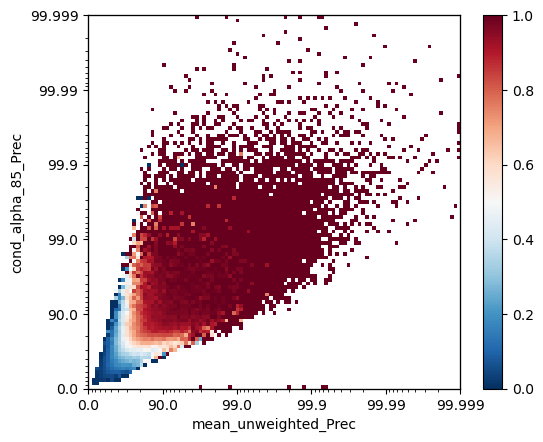

In [9]:
%matplotlib inline
data, noise, count = jd.get_mcs_bin_fraction(region_mask = np.logical_or(ocean, land), bin_noise_treshold= 1)
jd.plot_data(data, noise, vbds = (0,1))

/scratchx/mcarenso/ipykernel_1891042/749309000.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


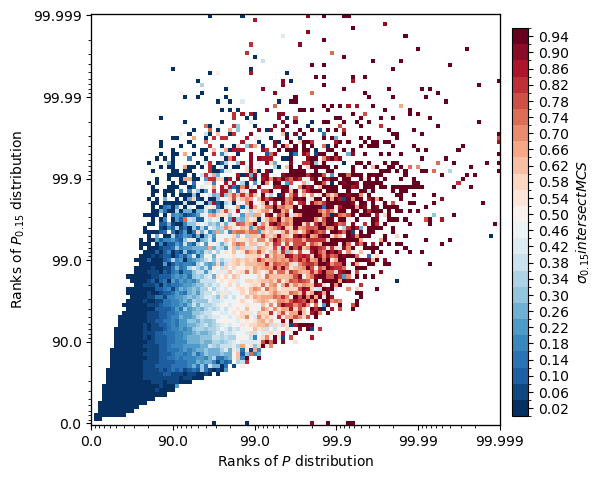

In [13]:
fig, ax  = plt.subplots(figsize = (5.35, 4.85))

cmap = plt.cm.RdBu_r
values_and_boundaries = np.arange(0, 1, 0.02)
values = values_and_boundaries[1::2]
boundaries  = values_and_boundaries[::2]
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N)

ax, cbar = jd.plot_var_id_func_over_jdist('MCS_cond_Prec_15', func = 'intersection', mask = np.logical_or(land, ocean), cmap = cmap, norm = norm, fig = fig, ax = ax)
cbar.remove()

# ax.set_title(r"$\rho_{0.5} $ for joint bins of $(P; P_{0.5})$")
ax.set_xlabel(r"Ranks of $P$ distribution")
ax.set_ylabel(r"Ranks of $P_{0.15}$ distribution")


cax = fig.add_axes([0.95, 0.14, 0.03, 0.8])  # [left, bottom, width, height]
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, ticks=values, spacing='proportional')

cbar.set_label(r'$\sigma_{0.15} intersect MCS$')
fig.tight_layout()
plt.savefig('discrete_threshold_on_joint_dist.png', bbox_inches='tight')

/scratchx/mcarenso/ipykernel_1891042/719470813.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


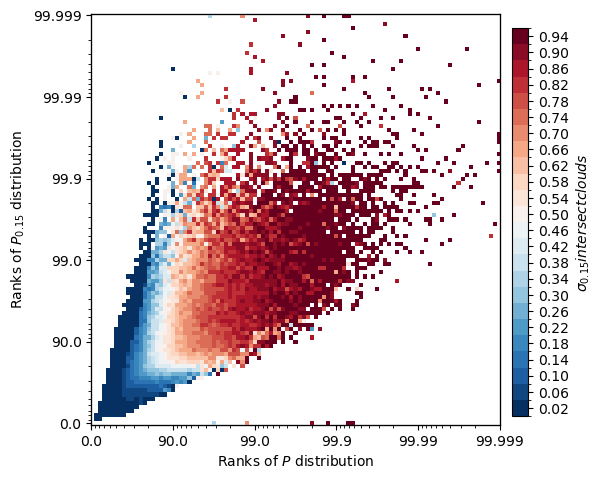

In [14]:
fig, ax  = plt.subplots(figsize = (5.35, 4.85))

cmap = plt.cm.RdBu_r
values_and_boundaries = np.arange(0, 1, 0.02)
values = values_and_boundaries[1::2]
boundaries  = values_and_boundaries[::2]
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N)

ax, cbar = jd.plot_var_id_func_over_jdist('clouds_cond_Prec_15', func = 'intersection', mask = np.logical_or(land, ocean), cmap = cmap, norm = norm, fig = fig, ax = ax)
cbar.remove()

# ax.set_title(r"$\rho_{0.5} $ for joint bins of $(P; P_{0.5})$")
ax.set_xlabel(r"Ranks of $P$ distribution")
ax.set_ylabel(r"Ranks of $P_{0.15}$ distribution")


cax = fig.add_axes([0.95, 0.14, 0.03, 0.8])  # [left, bottom, width, height]
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, ticks=values, spacing='proportional')

cbar.set_label(r'$\sigma_{0.15} intersect clouds$')
fig.tight_layout()
plt.savefig('discrete_threshold_on_joint_dist.png', bbox_inches='tight')

/scratchx/mcarenso/ipykernel_1063532/1709801976.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


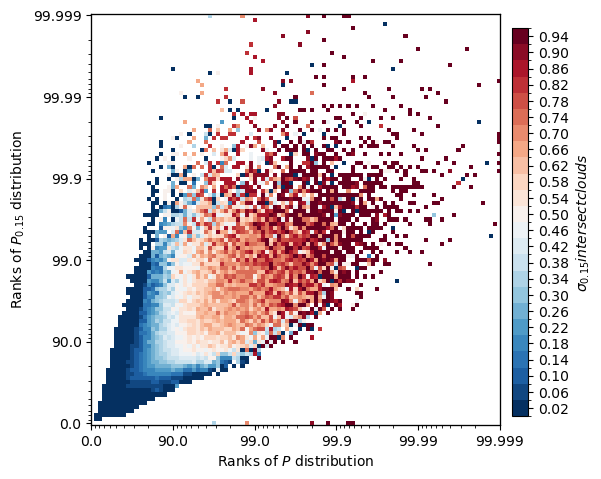

In [14]:
fig, ax  = plt.subplots(figsize = (5.35, 4.85))

cmap = plt.cm.RdBu_r
values_and_boundaries = np.arange(0, 1, 0.02)
values = values_and_boundaries[1::2]
boundaries  = values_and_boundaries[::2]
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N)

ax, cbar = jd.plot_var_id_func_over_jdist('vDCS_cond_Prec_15', func = 'intersection', mask = np.logical_or(land, ocean), cmap = cmap, norm = norm, fig = fig, ax = ax)
cbar.remove()

# ax.set_title(r"$\rho_{0.5} $ for joint bins of $(P; P_{0.5})$")
ax.set_xlabel(r"Ranks of $P$ distribution")
ax.set_ylabel(r"Ranks of $P_{0.15}$ distribution")


cax = fig.add_axes([0.95, 0.14, 0.03, 0.8])  # [left, bottom, width, height]
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, ticks=values, spacing='proportional')

cbar.set_label(r'$\sigma_{0.15} intersect clouds$')
fig.tight_layout()
plt.savefig('discrete_threshold_on_joint_dist.png', bbox_inches='tight')

In [7]:
#### HOW TO BUILD intersection of cloud systems and cond_Prec 

# import os 
# cloud_cond_var_id = "vDCS_cond_Prec_15"
# sigma = jd.prec.Sigma_cond_alpha_85_Prec
# mcs_cond = gr.get_var_id_ds(cloud_cond_var_id)
# sigma_mcs = mcs_cond.Rel_surface.sum(axis = 3) ## add this
# mcs_cond["intersection_"+cloud_cond_var_id] = sigma_mcs/sigma ## add this 
# mcs_cond_file = gr.get_var_ds_file(cloud_cond_var_id)
# os.remove(mcs_cond_file)
# mcs_cond.to_netcdf(mcs_cond_file)

## compare with sam 4km 

In [ ]:
# settings_path = 'settings/tropics_20d.yaml'
# ## Load handler and pass settings
# hdlr_sam = handler.Handler(settings_path)
# # ## Initiate variables
# cs_sam = casestudy.CaseStudy(hdlr_sam, overwrite = False ,verbose = False)
# # ## Make grid and load data on grid 
# gr_sam = grid.Grid(cs_sam, fast = True, overwrite= False, verbose_steps = False, verbose = False)
# # # ## Load storms 
# st_sam = storm_tracker.StormTracker(gr_sam, label_var_id = "MCS_label", overwrite = False)

# jd_sam = joint_distrib.JointDistribution(gr_sam, st_sam, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_85_Prec", nd=5, overwrite = False, dist_mask = False)

In [ ]:
# %matplotlib inline 
# plt.plot(jd.dist1.bins, label = 'IMERG')
# plt.plot(jd_sam.dist1.bins, label = 'SAM 4km')
# plt.title("Coarse-grained bins precip value")
# plt.legend()

In [ ]:
# %matplotlib inline 
# plt.plot(jd.dist2.bins, label = 'IMERG')
# plt.plot(jd_sam.dist2.bins, label = 'SAM 4km')
# plt.title("km-scale bins precip value")
# plt.legend()

In [ ]:
def denormalize(x, min_val, max_val):
        """"
        for optimzing in min-max standardize space
        """
        return x * (max_val - min_val) + min_val

## density

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4.8, 3.7))
jd.plot_data(jd.bincount, scale = 'log', label = "bincount", cmap=plt.cm.magma_r , fig = fig, ax = ax)
plt.tight_layout()

In [ ]:
fig, ax  = plt.subplots(figsize = (5.35, 4.85))

cmap = sns.color_palette("icefire", as_cmap=True)
values_and_boundaries = np.arange(0, 62, 2)
values = values_and_boundaries[1::2]
boundaries  = values_and_boundaries[::2]
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N)

ax, cbar = jd.plot_var_id_func_over_jdist('Prec', func = 'threshold_cond_alpha_85', mask = ocean, cmap = cmap, norm = norm, fig = fig, ax = ax)
cbar.remove()

# ax.set_title(r"$\rho_{0.5} $ for joint bins of $(P; P_{0.5})$")
ax.set_xlabel(r"Ranks of $P$ distribution")
ax.set_ylabel(r"Ranks of $P_{0.15}$ distribution")


cax = fig.add_axes([0.95, 0.14, 0.03, 0.8])  # [left, bottom, width, height]
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, ticks=values, spacing='proportional')

cbar.set_label(r'$\rho_{0.15} $')
fig.tight_layout()
plt.savefig('discrete_threshold_on_joint_dist.png', bbox_inches='tight')

In [ ]:
fig, ax  = plt.subplots(figsize = (5.35, 4.85))

cmap = sns.color_palette("icefire", as_cmap=True)
values_and_boundaries = np.arange(0, 0.05+0.001, 0.001)
values = values_and_boundaries[1::2]
boundaries  = values_and_boundaries[::2]


norm = mpl.colors.BoundaryNorm(boundaries, cmap.N)

ax, cbar = jd.plot_var_id_func_over_jdist('Prec', func = 'Sigma_cond_alpha_85', mask = ocean, cmap = cmap, norm = norm, fig = fig, ax = ax)
cbar.remove()

# ax.set_title(r"$\sigma_{0.5} $ for joint bins of $(P; P_{0.5})$")
ax.set_xlabel(r"Ranks of $P$ distribution")
ax.set_ylabel(r"Ranks of $P_{0.15}$ distribution")


cax = fig.add_axes([0.95, 0.14, 0.03, 0.8])  # [left, bottom, width, height]
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, ticks=boundaries, spacing='proportional')

cbar.set_label(r'$\sigma_{0.15}$')
plt.tight_layout()
plt.savefig('discrete_surface_ratio_on_joint_dist.png', bbox_inches='tight')

## normalized density

In [ ]:
%matplotlib inline

fig, axs = plt.subplots(1, 3, figsize=(3.75*4.8, 4.85))

jd.plot_data(jd.bincount, scale = 'log', label = "bincount", cmap=plt.cm.magma_r , fig = fig, ax = axs[0])
axs[0].set_title("Les légendes sont à refaire")
jd.plot(mask = False, branch=False, fig = fig, ax = axs[1])
jd.plot(mask = True, branch = True, fig = fig, ax = axs[2])
plt.tight_layout()

In [ ]:
import cartopy.crs as ccrs
import os 
%matplotlib inline
# Show frequency maps of extremes in the 4 regions (normalized by total bincount in mask?)

jd.make_mask()

mask_all = [jd.mask_branch1_90, jd.mask_coloc_c_90, jd.mask_coloc_ac_90, jd.mask_branch2_90]
mask_names = 'Convective only','Mostly convective','Mostly mesoscale','Mesoscale only'
mask_labels = 'conv','mostlyconv','mostlyacc','acc'
figdir = ''

# rank  = 2 # 2 , 3,4

# if rank == 1 : 
#     rank_min, rank_max = 90, 99
# elif rank == 2 :
#     rank_min, rank_max = 99, 99.9
# elif rank == 3 :
#     rank_min, rank_max = 99.9, 99.99
# elif rank == 4 :
#     rank_min, rank_max = 99.99, 100

rank_conv_min = 90
rank_acc_min = 90

mask_rank_conv = np.outer(jd.dist1.ranks >= 0, jd.dist2.ranks >= rank_conv_min)
mask_rank_acc = np.outer(jd.dist1.ranks >= rank_acc_min , jd.dist2.ranks >= 0)
            
mask_rank_all = [mask_rank_conv, mask_rank_conv, mask_rank_acc, mask_rank_acc]

for mask,mask_rank, mask_name,mask_label in zip(mask_all,mask_rank_all,mask_names,mask_labels):
    
    print(mask_name)
    mask_ranked = np.logical_and(mask, mask_rank)
    mask_yxt = jd.get_mask_yxt_from_mask_jdist(mask_ranked)
    # mask_yxt_ocean = np.logical_and(mask_yxt, ocean)
    ax, cbar = jd.make_map(mask_yxt, data = None)

    # lon_min, lon_max = 215, 280 #gr.lon_slice.start , gr.lon_slice.stop
    # lat_min, lat_max = 5, 20#gr.lat_slice.start, gr.lat_slice.stop
    # ax.plot([lon_min, lon_max, lon_max, lon_min, lon_min],
    #             [lat_min, lat_min, lat_max, lat_max, lat_min],
    #             color='red', linestyle='-', linewidth=2, transform=ccrs.PlateCarree(), label = "Eastern Pacific ITCZ")
    lon_min, lon_max = 125, 185 #gr.lon_slice.start , gr.lon_slice.stop
    lat_min, lat_max = 0, 25#gr.lat_slice.start, gr.lat_slice.stop
    ax.plot([lon_min, lon_max, lon_max, lon_min, lon_min],
                [lat_min, lat_min, lat_max, lat_max, lat_min],
                color='blue', linestyle='-', linewidth=2, transform=ccrs.PlateCarree(), label = "Pacific Warmpool")
    
    # ax.legend()
    
    ax.set_title(mask_name)

## MCS Morpho

In [ ]:
# # # Propagate mcs info to grid
# jd.add_mcs_var_from_labels("growth_rate", norm_rel_surf = 'lin', compat='override')
# jd.add_mcs_var_from_labels("norm_growth_rate", norm_rel_surf = 'lin', compat='override')
# jd.add_mcs_var_from_labels("s_max", norm_rel_surf = 'lin', compat='override')
# jd.add_mcs_var_from_labels("duration", norm_rel_surf = 'lin', compat='override')
# jd.add_mcs_var_from_labels("vavg", norm_rel_surf = 'lin', compat='override')

In [ ]:
mcs = gr.get_var_id_ds("MCS_label")

In [ ]:
grid_surf = gr.grid_surface
caracteric_length = np.sqrt(grid_surf)*1000*np.sqrt(2)
caracteristic_time = caracteric_length[:,:,np.newaxis]/mcs.vavg_surf_adj
duration_seconds = mcs.duration_surf_adj*7200
stationary_time = xr.where(duration_seconds>caracteristic_time, caracteristic_time, duration_seconds)
mcs["stationary_time"]=stationary_time
file_mcs = gr.get_var_ds_file("MCS_label")
import os 
os.remove(file_mcs)
mcs.to_netcdf(file_mcs)

In [ ]:
mcs  = gr.get_var_id_ds("MCS_label")
# np.sum(~np.isnan(mcs.growth_rate_surf_adj.values))
# mcs

In [ ]:
var_id = "growth_rate_surf_adj"
var_cond_list = [0, 0.03, 0.06, 0.12, 1]
func = "MCS"
stipple_threshold=0.1
vmax = mcs[var_id].max()
vmin = mcs[var_id].min()
boundaries = [denormalize(x, vmin, vmax).values for x in var_cond_list]
jd.plot_var_boundaries_on_jdist(var_id = var_id, func = func, boundaries = boundaries, mask = True, stipple_threshold=stipple_threshold, figsize = (5.23, 4.85))

In [ ]:
var_id = "s_max_surf_adj"
var_cond_list = [0, 0.025, 0.06, 0.12, 1]
func = "MCS"
stipple_threshold=0.1
vmax = mcs[var_id].max()
vmin = mcs[var_id].min()
boundaries = [denormalize(x, vmin, vmax).values for x in var_cond_list]
jd.plot_var_boundaries_on_jdist(var_id = var_id, func = func, boundaries = boundaries, mask = True, stipple_threshold=stipple_threshold, figsize = (5.23, 4.85))

In [ ]:
var_id = "duration_surf_adj"
var_cond_list = [0, 0.15, 0.25, 0.35, 1]
func = "MCS"
stipple_threshold=0.1
vmax = mcs[var_id].max()
vmin = mcs[var_id].min()
boundaries = [denormalize(x, vmin, vmax).values for x in var_cond_list]
jd.plot_var_boundaries_on_jdist(var_id = var_id, func = func, boundaries = boundaries, mask = True, stipple_threshold=stipple_threshold, figsize = (5.23, 4.85))

In [ ]:
var_id = "stationary_time"
var_cond_list = [0,0.14, 0.22, 0.32, 1]
func = "MCS"
stipple_threshold=0.1
vmax = mcs[var_id].max()
vmin = mcs[var_id].min()
boundaries = [denormalize(x, vmin, vmax).values for x in var_cond_list]
jd.plot_var_boundaries_on_jdist(var_id = var_id, func = func, boundaries = boundaries, mask = True, stipple_threshold=stipple_threshold)

In [ ]:
var_id = "vavg_surf_adj"
var_cond_list = [0, 0.075, 0.11, 0.18, 1]
func = "MCS"
stipple_threshold=0.1
vmax = mcs[var_id].max()
vmin = mcs[var_id].min()
boundaries = [denormalize(x, vmin, vmax).values for x in var_cond_list]
jd.plot_var_boundaries_on_jdist(var_id = var_id, func = func, boundaries = boundaries, mask = True, stipple_threshold=stipple_threshold)